# Exploratory Data Analysis (EDA)
#### objective:
    Explore the dataset to uncover patterns, identify data quality issues, and form hypotheses that will guide the  feature engineering.
* Load the Data
* Overview Data
* Summery Statitcs metrics
* Check the distribution of Numerical and Catagorical Features
* Correlation Analysis
* Identify Missing Values
* Detect Outliers 


#### Load the Data


In [1]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('../data/raw/data.csv')
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [3]:
# Quick look at the data
df.info() #check the number of rows and columns datatypes and missing values
df.shape # check the number of rows and columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

(95662, 16)

#### Summary Statistics

In [4]:
# summery statistics for numerical columns 
df.describe().T


,count,mean,std,min,25%,50%,75%,max
CountryCode,95662.0,256.000000,0.000000,256.0,256.0,256.0,256.0,256.0
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-50.0,1000.0,2800.0,9880000.0
Value,95662.0,9900.583941,123122.087776,2.0,275.0,1000.0,5000.0,9880000.0
PricingStrategy,95662.0,2.255974,0.732924,0.0,2.0,2.0,2.0,4.0
FraudResult,95662.0,0.002018,0.044872,0.0,0.0,0.0,0.0,1.0


###### 🚨 Key EDA warnings

* ⚠ Severe outliers in monetary variables
* ⚠ Skewed distributions (mean ≠ median)
* ⚠ Zero-variance features (CountryCode)
* ⚠ Class imbalance in FraudResult

In [5]:
# summery statistics for categorical columns
df.describe(include='object').T

,count,unique,top,freq
TransactionId,95662,95662,TransactionId_76871,1
BatchId,95662,94809,BatchId_67019,28
AccountId,95662,3633,AccountId_4841,30893
SubscriptionId,95662,3627,SubscriptionId_3829,32630
CustomerId,95662,3742,CustomerId_7343,4091
CurrencyCode,95662,1,UGX,95662
ProviderId,95662,6,ProviderId_4,38189
ProductId,95662,23,ProductId_6,32635
ProductCategory,95662,9,financial_services,45405
ChannelId,95662,4,ChannelId_3,56935


###### Key Insights
* Dataset is transaction-level, not customer-level
* Strong repeat behavior per customer/account
* Some columns are identifiers only (drop later)
*  Some columns have no variance (CurrencyCode)
* Time-based features will be critical for RFM & proxy default

##### Distribution for Numerical Columns


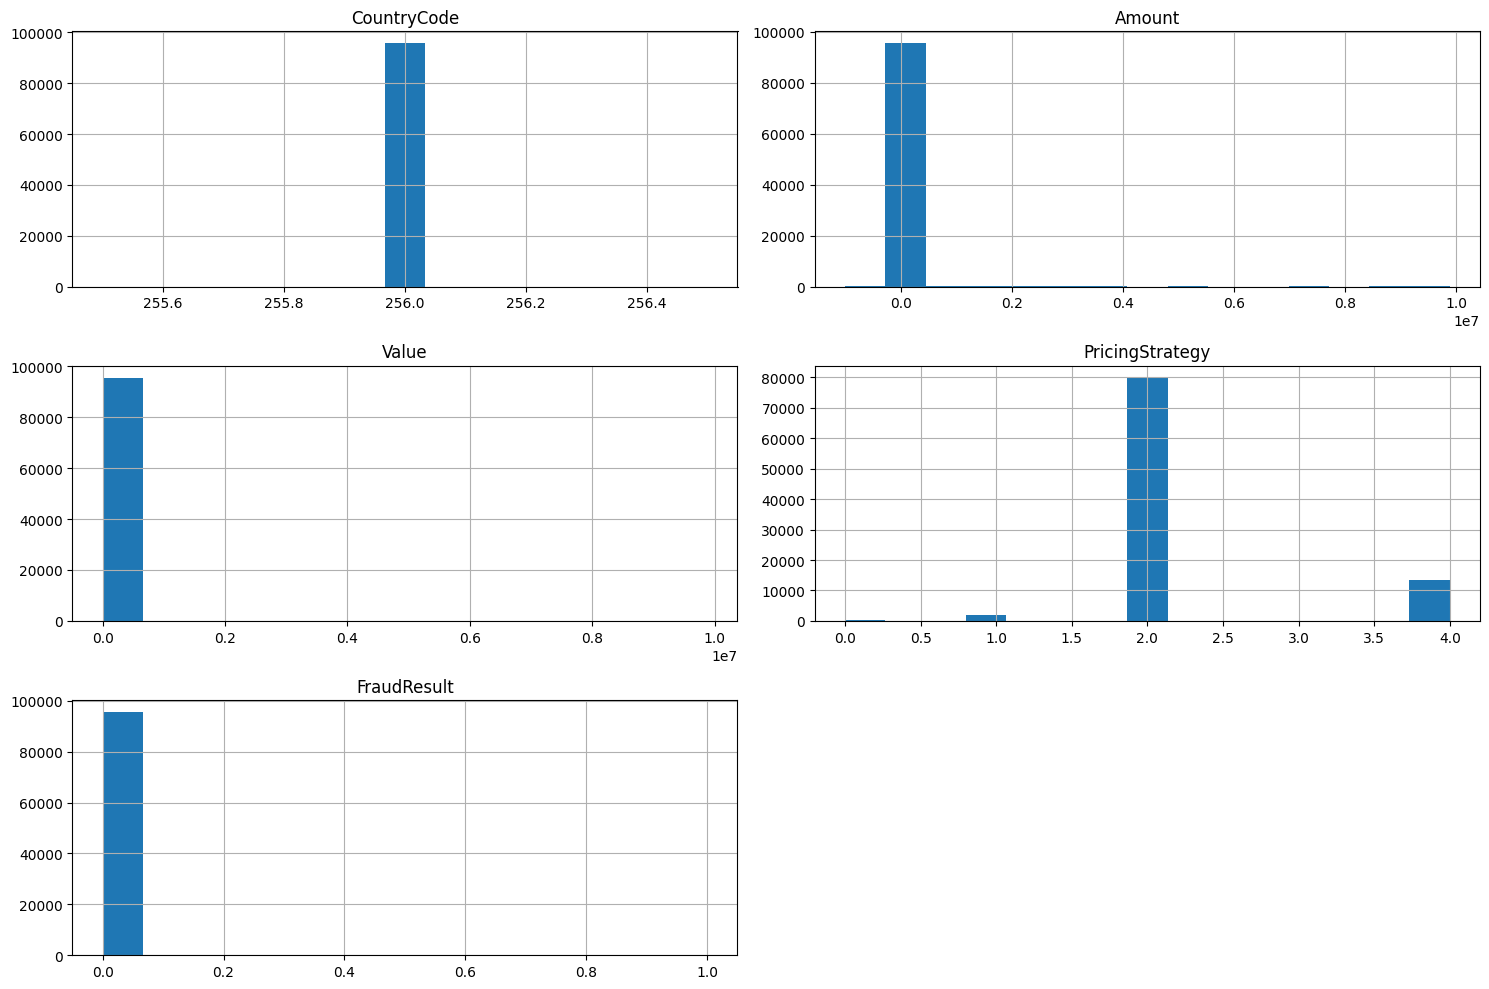

In [6]:
# histogram for all numerical columns
numerical_cols=df.select_dtypes(include=['int64','float64']).columns
df[numerical_cols].hist(bins=15, figsize=(15,10))
plt.tight_layout()
plt.show()

##### Key Insights From Histogram Visualization
* Core Issue: 
Extreme class imbalance (~99% non-fraud vs ~1% fraud) in FraudResult makes standard ML fail.

* Data Patterns:

   Amount & Value: Right-skewed → needs log transformation

   CountryCode & PricingStrategy: Categorical disguised as numeric → needs encoding

#### Catagorical Feature Distribution

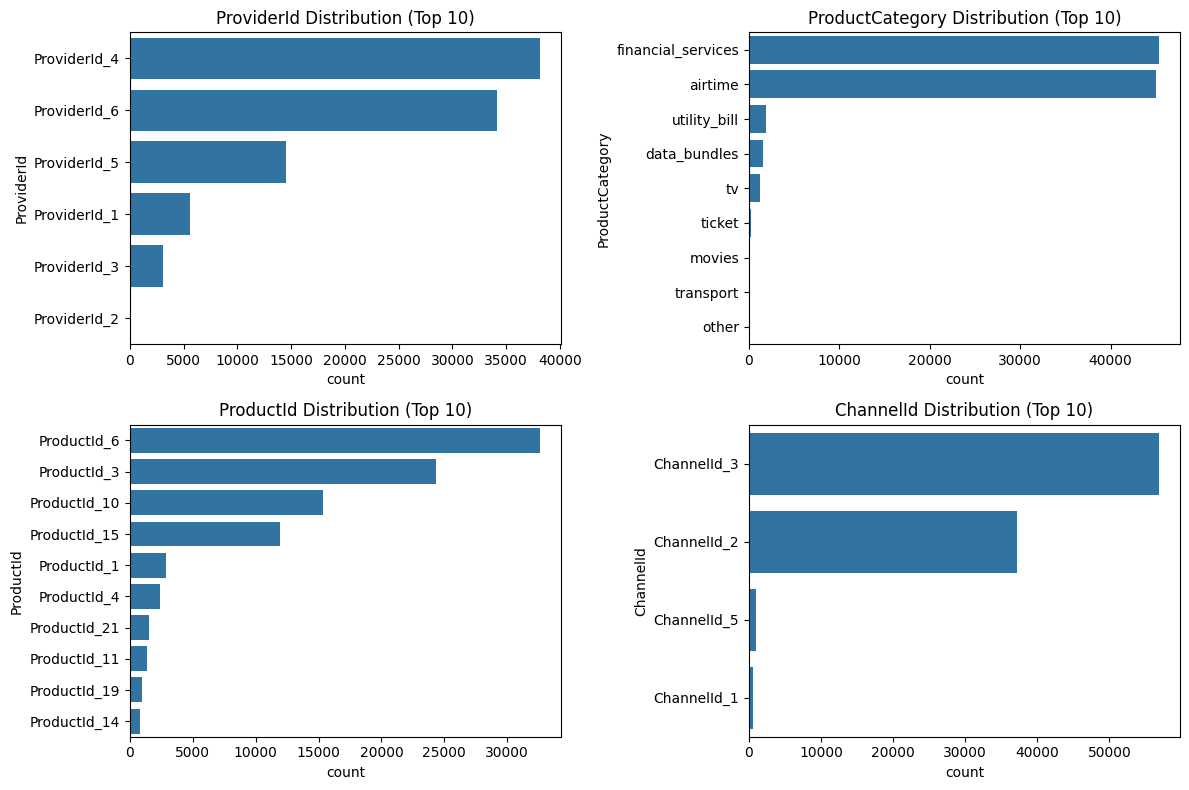

In [9]:
selected_categorical_cols = [
    "ProviderId",
    "ProductCategory",
    "ProductId",
    "ChannelId"
]

TOP_N = 10

num_cols = len(selected_categorical_cols)
cols = 2
rows = (num_cols + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(selected_categorical_cols):
    top_categories = df[col].value_counts().nlargest(TOP_N).index
    sns.countplot(
        y=col,
        data=df,
        order=top_categories,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} Distribution (Top {TOP_N})")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



##### 📊 Key Insights & Recommendations

###### 🔍 High Concentration = High Risk

* 🏢 Provider: ProviderId_4

* 📦 Product: ProductId_6

* 🏷️ Category: financial_services

* 📡 Channel: ChannelId_3
* ⚠️ Risk: Business is successful but vulnerable to single-point failures.

###### 🌱 Diversification Potential Exists

* 📈 Long tail of providers, products, and categories → opportunity to grow.

* 🧑‍💼 Customers prefer financial services via ChannelId_3 → clear preference.

###### 🚀 Growth Levers:

* 🔄 Develop secondary providers (ProviderId_6, 5, 1, 3, 2)

* 📺 Boost non-financial categories (airtime, data, utility, TV)

* 📶 Optimize other channels (ChannelId_2, 5, 1)

#### Correlation Analysis

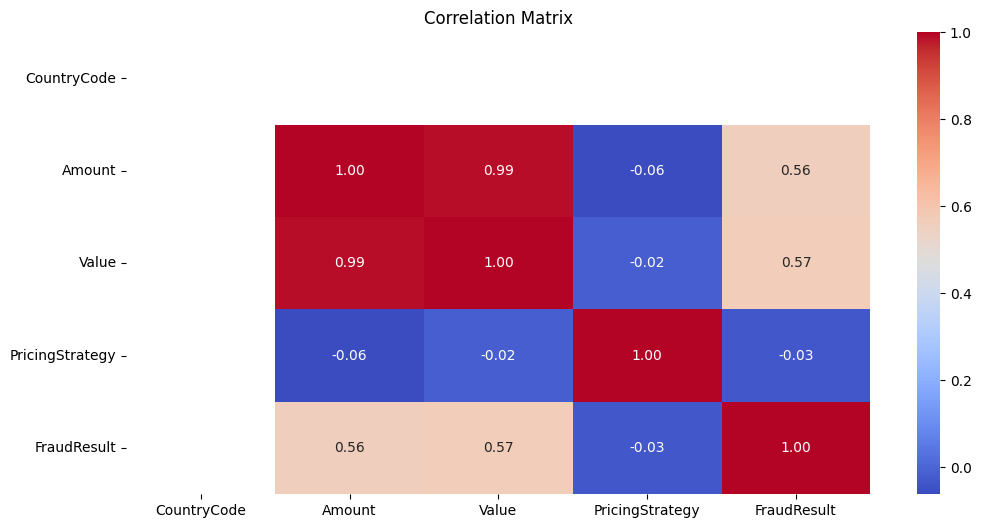

In [7]:
# corrrelation analysis on numerical cols
corr=df[numerical_cols].corr()

### Heatmap to show the correlation among cols
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap='coolwarm',fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### 📊 Insights from Correlation Heatmap
* Fraud Detection Focus:

* Monitor high-value transactions more closely.

* Fraud systems likely use amount/value as key indicators.

* Data Redundancy:

* Consider using either Amount or Value — not both — to avoid multicollinearity in models.

* Pricing Strategy Neutrality:

* Pricing does not seem to affect fraud rates → can adjust pricing without directly impacting fraud risk.

#### Identifying Missing Values

In [11]:
# check missing value for our data
missing_value=df.isnull().sum().sort_values(ascending=False) # orders missing values
missing_percent=(df.isnull().sum()/len(df))*100 # calculates the percentage of missing values
pd.DataFrame({'missing count':missing_value,'missing_percent':missing_percent}) # converts to DataFrame


,missing count,missing_percent
TransactionId,0,0.0
BatchId,0,0.0
AccountId,0,0.0
SubscriptionId,0,0.0
CustomerId,0,0.0
CurrencyCode,0,0.0
CountryCode,0,0.0
ProviderId,0,0.0
ProductId,0,0.0
ProductCategory,0,0.0


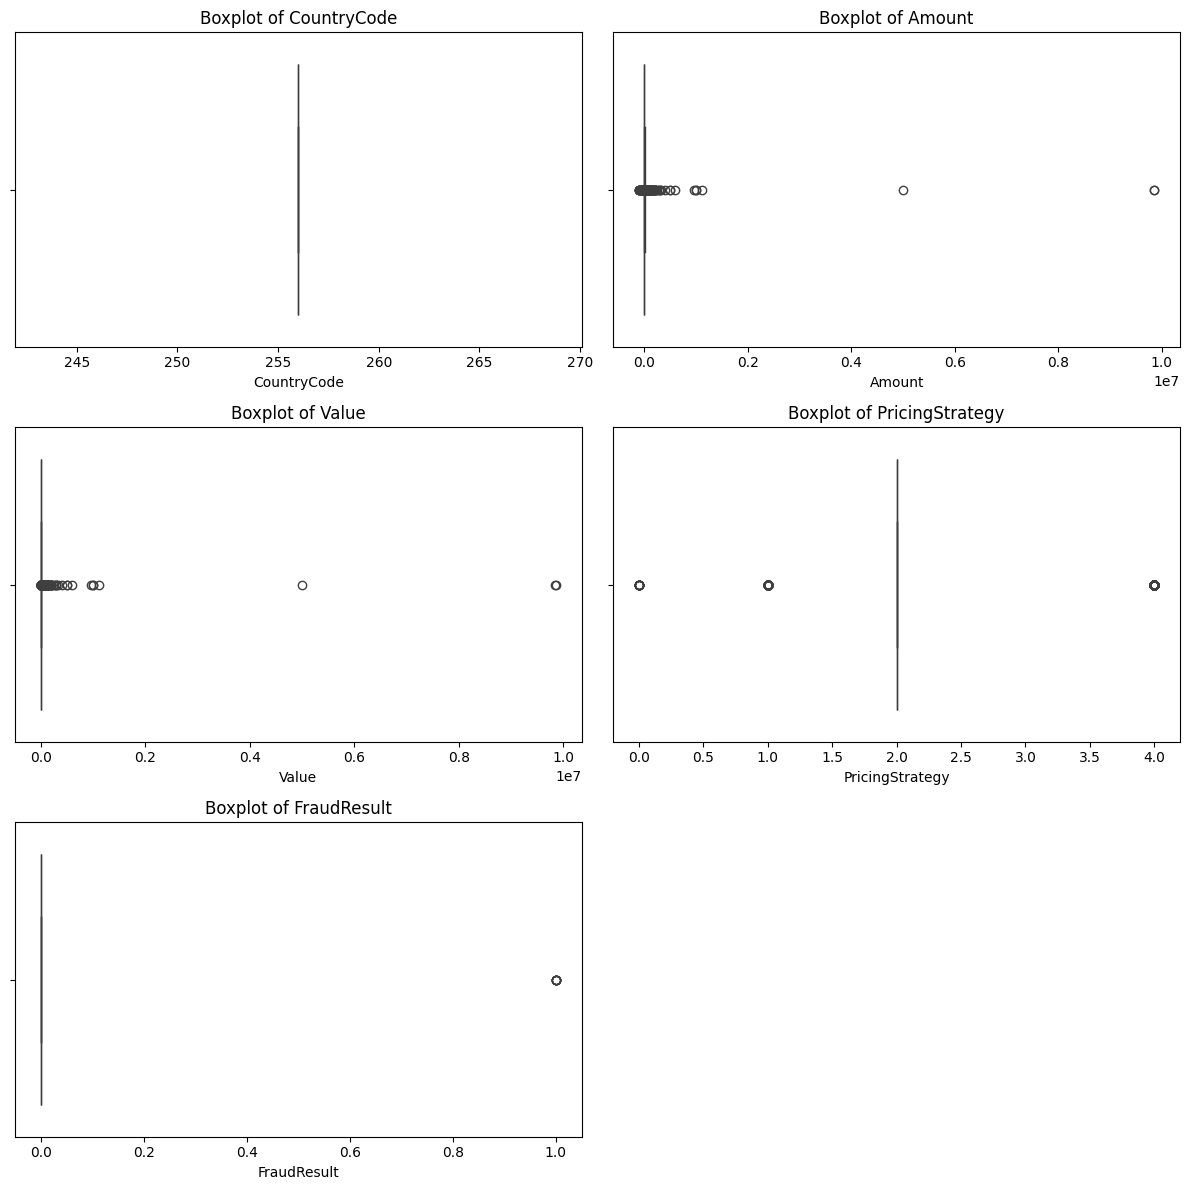

In [12]:


# Numerical columns
numerical_cols = df.select_dtypes(include='number').columns

# Sample to speed up boxplots
sample_df = df.sample(5000, random_state=42)

# Layout
cols = 2
rows = (len(numerical_cols) + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=sample_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
